In [1]:
from Eval_basis import *
import pandas as pd
from tqdm import tqdm
from scipy import sparse
from scvi.dataset import EbiData, MouseAtlas, UnionDataset, AnnDatasetFromAnnData
import scanpy as sc


[2019-10-09 15:13:48,221] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [2]:
np.random.seed(1)
%matplotlib inline

In [3]:
data_full = EbiData("./data", experiment="E-ENAD-15")

[2019-10-08 14:07:13,000] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2019-10-08 14:07:13,047] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-08 14:07:13,050] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-08 14:07:14,170] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2019-10-08 14:07:15,219] INFO - scvi.dataset.dataset | Downsampled from 50896 to 35577 cells


In [4]:
data_big_mapped = UnionDataset("./data", gene_map_load_filename="gene_maps/ensembl_mouse_genes-proteincoding", low_memory=False)
data_big_mapped.join_datasets(data_source="memory", data_target="memory", gene_datasets= [data_full])
data_big_mapped.filter_cell_types(np.array([ct for ct in data_big_mapped.cell_types if ct != "not available"]))

Concatenating datasets: 100%|██████████| 1/1 [00:34<00:00, 34.03s/it]
[2019-10-08 14:07:49,756] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 14:07:50,835] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2019-10-08 14:07:50,836] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 14:07:50,837] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2019-10-08 14:07:50,841] INFO - scvi.dataset.dataset | Joined 1 datasets to one of shape 35577 x 22250.
[2019-10-08 14:07:50,846] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 14:07:51,845] INFO - scvi.dataset.dataset | Downsampled from 35577 to 31394 cells


In [5]:
agg = data_full.obs.groupby(["Sample Characteristic[organism part]", "cell_types"]).size()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(agg.sort_index())

Sample Characteristic[organism part]      cell_types                                        
aorta                                     endothelial cell                                       188
                                          erythrocyte                                             91
                                          fibroblast                                              70
                                          not available                                          694
                                          professional antigen presenting cell                    59
ascending colon                           Brush cell of epithelium proper of large intestine      53
                                          enterocyte of epithelium of large intestine            761
                                          enteroendocrine cell                                    29
                                          epithelial cell of large intestine                    141

In [6]:
def do_procedure(dataset, ebi_data, model_filename, tsne_filename, **kwargs):
    n_epochs = 100
    colors = None

    trainer = train_vae(dataset, "./data", f"../trained_models/{model_filename}", n_epochs=n_epochs)
    
    dot_size = (mpl.rcParams['lines.markersize'] ** 2.0)

    _ = plot_tsne(trainer, trainer.model, ebi_data,
                  f"./plots/tissue_wise/{tsne_filename}",
                  image_datatype="pdf", colors=colors, s=dot_size, edgecolors='black', **kwargs)

In [7]:
def do_scores(dataset, model_filename, dataset_scoring, **kwargs):
    n_epochs = 100
    colors = None

    trainer = train_vae(dataset, "./data", f"../trained_models/{model_filename}", n_epochs=n_epochs)
    posterior = trainer.create_posterior(trainer.model, dataset_scoring, indices=np.arange(len(dataset_scoring)))
    return posterior.clustering_scores()

In [8]:
complete_mouse = UnionDataset("./data",
                              gene_map_load_filename="gene_maps/ensembl_mouse_genes-proteincoding",
                              data_load_filename="mouse_data_all.loom",
                              low_memory=True)


[2019-10-08 14:07:51,981] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.


In [13]:
# do_procedure(data_big_mapped, data_big_mapped, "eval_data_full", f"ebi_full_tsne_nolegend", hide_legend=True)

do_procedure(complete_mouse, data_big_mapped, "mouse_data_full", f"ebi_in_mouse_data_full_tsne_nolegend", hide_legend=True)
do_procedure(complete_mouse, data_big_mapped, "ebi_data_full", f"ebi_in_ebi_data_full_tsne_nolegend", hide_legend=True)
do_procedure(complete_mouse, data_big_mapped, "mouse_atlas", f"ebi_in_mouse_atlas_tsne_nolegend", hide_legend=True)
do_procedure(complete_mouse, data_big_mapped, "mouse_muris_senis", f"ebi_in_mouse_muris_senis_tsne_nolegend", hide_legend=True)

IndentationError: unexpected indent (<ipython-input-13-c23bcb4206f0>, line 2)

In [7]:
log_lhood = dict()
n_epochs = 100
colors=None
for tissue in np.unique(agg.index.get_level_values(0)): 
    print("Training VAE for tissue ", tissue)
    cutout_cts = agg[tissue].index.values
    if "not available" in cutout_cts:
        cutout_cts = np.delete(cutout_cts, np.where(cutout_cts == "not available")[0])

    rem_ct = data_big_mapped.cell_types[~np.isin(data_big_mapped.cell_types, cutout_cts)]
    data_small = copy.deepcopy(data_big_mapped)
    data_big = copy.deepcopy(data_big_mapped)

    data_small.filter_cell_types(cutout_cts)
    data_big.filter_cell_types(rem_ct)
    
    log_lhood[tissue] = compute_log_likelihood(complete_mouse, "./data", f"../trained_models/small_big_experiment/small_{tissue.replace(" ", "_")}_data_portion", data_small, n_samples_mc=1000)
 

Training VAE for tissue  aorta


[2019-09-09 19:10:47,854] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:10:47,994] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3985 cells
[2019-09-09 19:10:47,997] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:10:48,848] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27409 cells


Loading model from file. No training.
Training VAE for tissue  ascending colon


[2019-09-09 19:12:27,417] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:12:27,563] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2725 cells
[2019-09-09 19:12:27,566] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:12:28,420] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28669 cells


Loading model from file. No training.
Training VAE for tissue  back skin


[2019-09-09 19:13:34,022] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:13:34,142] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2818 cells
[2019-09-09 19:13:34,145] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:13:34,997] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28576 cells


Loading model from file. No training.
Training VAE for tissue  bone marrow


[2019-09-09 19:14:42,571] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:14:42,768] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6015 cells
[2019-09-09 19:14:42,772] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:14:43,557] INFO - scvi.dataset.dataset | Downsampled from 31394 to 25379 cells


Loading model from file. No training.
Training VAE for tissue  cerebellum


[2019-09-09 19:17:04,944] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:17:05,180] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7502 cells
[2019-09-09 19:17:05,183] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:17:05,920] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23892 cells


Loading model from file. No training.
Training VAE for tissue  cerebral cortex


[2019-09-09 19:20:02,261] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:20:02,501] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7482 cells
[2019-09-09 19:20:02,504] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:20:03,254] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23912 cells


Loading model from file. No training.
Training VAE for tissue  descending colon


[2019-09-09 19:22:59,125] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:22:59,250] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2725 cells
[2019-09-09 19:22:59,253] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:23:00,106] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28669 cells


Loading model from file. No training.
Training VAE for tissue  diaphragm


[2019-09-09 19:24:05,250] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:24:05,354] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3310 cells
[2019-09-09 19:24:05,357] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:24:06,220] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28084 cells


Loading model from file. No training.
Training VAE for tissue  endocrine pancreas


[2019-09-09 19:25:24,825] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:25:24,968] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3746 cells
[2019-09-09 19:25:24,970] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:25:25,801] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27648 cells


Loading model from file. No training.
Training VAE for tissue  exocrine pancreas


[2019-09-09 19:26:54,561] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:26:54,695] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3746 cells
[2019-09-09 19:26:54,698] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:26:55,536] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27648 cells


Loading model from file. No training.
Training VAE for tissue  gonadal fat pad


[2019-09-09 19:28:24,338] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:28:24,544] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-09-09 19:28:24,547] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:28:25,319] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.
Training VAE for tissue  heart


[2019-09-09 19:31:05,184] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:31:05,316] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4092 cells
[2019-09-09 19:31:05,319] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:31:06,152] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27302 cells


Loading model from file. No training.
Training VAE for tissue  heart left atrium


[2019-09-09 19:32:42,503] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:32:42,648] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-09-09 19:32:42,651] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:32:43,494] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.
Training VAE for tissue  heart left atrium and heart right atrium


[2019-09-09 19:34:34,462] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:34:34,537] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1643 cells
[2019-09-09 19:34:34,540] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:34:35,481] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29751 cells


Loading model from file. No training.
Training VAE for tissue  heart left ventricle


[2019-09-09 19:35:14,993] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:35:15,136] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-09-09 19:35:15,138] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:35:15,940] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.
Training VAE for tissue  heart right atrium


[2019-09-09 19:37:06,890] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:37:07,032] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-09-09 19:37:07,035] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:37:07,866] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.
Training VAE for tissue  heart right ventricle


[2019-09-09 19:38:58,873] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:38:59,014] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-09-09 19:38:59,017] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:38:59,862] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.
Training VAE for tissue  hippocampus


[2019-09-09 19:40:50,778] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:40:50,996] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7482 cells
[2019-09-09 19:40:50,999] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:40:51,741] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23912 cells


Loading model from file. No training.
Training VAE for tissue  interscapular brown adipose tissue


[2019-09-09 19:43:47,651] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:43:47,852] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-09-09 19:43:47,854] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:43:48,626] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.
Training VAE for tissue  kidney


[2019-09-09 19:46:28,361] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:46:28,454] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2936 cells
[2019-09-09 19:46:28,457] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:46:29,336] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28458 cells


Loading model from file. No training.
Training VAE for tissue  limb muscle


[2019-09-09 19:47:39,400] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:47:39,544] INFO - scvi.dataset.dataset | Downsampled from 31394 to 5312 cells
[2019-09-09 19:47:39,547] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:47:40,365] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26082 cells


Loading model from file. No training.
Training VAE for tissue  liver


[2019-09-09 19:49:45,638] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:49:45,706] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1984 cells
[2019-09-09 19:49:45,709] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:49:46,610] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29410 cells


Loading model from file. No training.
Training VAE for tissue  lung


[2019-09-09 19:50:33,630] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:50:33,781] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4930 cells
[2019-09-09 19:50:33,784] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:50:34,587] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26464 cells


Loading model from file. No training.
Training VAE for tissue  mammary gland


[2019-09-09 19:52:31,297] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:52:31,435] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4262 cells
[2019-09-09 19:52:31,437] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:52:32,274] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27132 cells


Loading model from file. No training.
Training VAE for tissue  mesenteric adipose tissue


[2019-09-09 19:54:13,081] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:54:13,280] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-09-09 19:54:13,283] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:54:14,055] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.
Training VAE for tissue  spleen


[2019-09-09 19:56:53,835] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:56:53,907] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2257 cells
[2019-09-09 19:56:53,910] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:56:54,798] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29137 cells


Loading model from file. No training.
Training VAE for tissue  striatum


[2019-09-09 19:57:48,597] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:57:48,816] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7502 cells
[2019-09-09 19:57:48,818] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 19:57:49,566] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23892 cells


Loading model from file. No training.
Training VAE for tissue  subcutaneous adipose tissue


[2019-09-09 20:00:46,006] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:00:46,207] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-09-09 20:00:46,210] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:00:46,975] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.
Training VAE for tissue  thymus


[2019-09-09 20:03:26,682] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:03:26,728] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1014 cells
[2019-09-09 20:03:26,730] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:03:27,647] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30380 cells


Loading model from file. No training.
Training VAE for tissue  tongue


[2019-09-09 20:03:52,021] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:03:52,100] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1385 cells
[2019-09-09 20:03:52,102] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:03:52,990] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30009 cells


Loading model from file. No training.
Training VAE for tissue  trachea


[2019-09-09 20:04:26,164] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:04:26,269] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3195 cells
[2019-09-09 20:04:26,272] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:04:27,146] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28199 cells


Loading model from file. No training.
Training VAE for tissue  urinary bladder


[2019-09-09 20:05:42,608] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:05:42,670] INFO - scvi.dataset.dataset | Downsampled from 31394 to 982 cells
[2019-09-09 20:05:42,673] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-09-09 20:05:43,584] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30412 cells


Loading model from file. No training.


In [8]:
for tissue, lkl in log_lhood.items():
    print(tissue.ljust(40), ":", round(lkl,1))

aorta                                    : 24310.3
ascending colon                          : 29460.1
back skin                                : 30357.4
bone marrow                              : 24258.3
cerebellum                               : 24374.3
cerebral cortex                          : 24435.3
descending colon                         : 30182.1
diaphragm                                : 23358.4
endocrine pancreas                       : 25343.4
exocrine pancreas                        : 25318.5
gonadal fat pad                          : 24067.3
heart                                    : 24211.3
heart left atrium                        : 24134.6
heart left atrium and heart right atrium : 28761.6
heart left ventricle                     : 24068.1
heart right atrium                       : 24147.5
heart right ventricle                    : 24044.9
hippocampus                              : 24283.5
interscapular brown adipose tissue       : 24109.3
kidney                         

In [38]:
from collections import defaultdict

log_likelihood = defaultdict(list)
cluster_scores_original = dict()
cluster_scores_grand = dict()
cluster_scores_ebi_data = dict()
cluster_scores_atlas = dict()
cluster_scores_mousemuris = dict()

n_epochs = 100
colors=None
for tissue in np.unique(agg.index.get_level_values(0)): 
    print("Training VAE for tissue ", tissue)
    cutout_cts = agg[tissue].index.values
    if "not available" in cutout_cts:
        cutout_cts = np.delete(cutout_cts, np.where(cutout_cts == "not available")[0])

    rem_ct = data_big_mapped.cell_types[~np.isin(data_big_mapped.cell_types, cutout_cts)]
    data_small = copy.deepcopy(data_big_mapped)
    data_big = copy.deepcopy(data_big_mapped)

    data_small.filter_cell_types(cutout_cts)
    data_big.filter_cell_types(rem_ct)
    
#     log_likelihood[tissue].append(compute_log_likelihood(complete_mouse, "./data", "../trained_models/mouse_data_full", data_small, n_samples_mc=1000))
#     log_likelihood[tissue].append(compute_log_likelihood(complete_mouse, "./data", "../trained_models/ebi_data_full", data_small, n_samples_mc=1000))
#     log_likelihood[tissue].append(compute_log_likelihood(complete_mouse, "./data", "../trained_models/mouse_atlas", data_small, n_samples_mc=1000))
#     log_likelihood[tissue].append(compute_log_likelihood(complete_mouse, "./data", "../trained_models/mouse_muris_senis", data_small, n_samples_mc=1000))
#     do_procedure(complete_mouse, data_small, "mouse_data_full", f"{tissue}_in_mouse_data_full_tsne_nolegend", hide_legend=True)
#     do_procedure(complete_mouse, data_small, "ebi_data_full", f"{tissue}_in_ebi_data_full_tsne_nolegend", hide_legend=True)
#     do_procedure(complete_mouse, data_small, "mouse_atlas", f"{tissue}_in_mouse_atlas_tsne_nolegend", hide_legend=True)
#     do_procedure(complete_mouse, data_small, "mouse_muris_senis", f"{tissue}_in_mouse_muris_senis_tsne_nolegend", hide_legend=True)
#     do_procedure(data_small, data_small, f"small_big_experiment/small_{tissue.replace(" ", "_")}_data_portion", f"{tissue.replace(" ", "_")}_in_small_tsne")
    cluster_scores_original[tissue] = do_scores(data_small, f'small_big_experiment/small_{tissue.replace(" ", "_")}_data_portion', data_small )
    cluster_scores_grand[tissue] = do_scores(complete_mouse, "../trained_models/mouse_data_full", data_small)
    cluster_scores_ebi_data[tissue] = do_scores(complete_mouse, "../trained_models/ebi_data_full", data_small)
    cluster_scores_atlas[tissue] = do_scores(complete_mouse, "../trained_models/mouse_atlas", data_small)
    cluster_scores_mousemuris[tissue] = do_scores(complete_mouse, "../trained_models/mouse_muris_senis", data_small)

cluster_scores_original["complete"] = do_scores(data_big_mapped, f'eval_data_full', data_big_mapped )
cluster_scores_grand["complete"] = do_scores(complete_mouse, "../trained_models/mouse_data_full", data_big_mapped)
cluster_scores_ebi_data["complete"] = do_scores(complete_mouse, "../trained_models/ebi_data_full", data_big_mapped)
cluster_scores_atlas["complete"] = do_scores(complete_mouse, "../trained_models/mouse_atlas", data_big_mapped)
cluster_scores_mousemuris["complete"] = do_scores(complete_mouse, "../trained_models/mouse_muris_senis", data_big_mapped)

                                                
print(cluster_scores_grand)
print(cluster_scores_ebi_data)
print(cluster_scores_atlas)
print(cluster_scores_mousemuris)

Training VAE for tissue  aorta


[2019-10-08 16:13:01,826] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:01,958] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3985 cells
[2019-10-08 16:13:01,961] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:02,794] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27409 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  ascending colon


[2019-10-08 16:13:16,272] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:16,411] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2725 cells
[2019-10-08 16:13:16,414] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:17,288] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28669 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  back skin


[2019-10-08 16:13:30,679] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:30,828] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2818 cells
[2019-10-08 16:13:30,832] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:31,686] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28576 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  bone marrow


[2019-10-08 16:13:44,092] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:44,292] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6015 cells
[2019-10-08 16:13:44,295] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:13:45,122] INFO - scvi.dataset.dataset | Downsampled from 31394 to 25379 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  cerebellum


[2019-10-08 16:14:56,707] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:14:56,954] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7502 cells
[2019-10-08 16:14:56,957] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:14:57,738] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23892 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  cerebral cortex


[2019-10-08 16:15:35,838] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:15:36,084] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7482 cells
[2019-10-08 16:15:36,086] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:15:36,870] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23912 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  descending colon


[2019-10-08 16:16:10,640] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:10,770] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2725 cells
[2019-10-08 16:16:10,773] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:11,674] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28669 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  diaphragm


[2019-10-08 16:16:24,342] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:24,451] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3310 cells
[2019-10-08 16:16:24,453] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:25,428] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28084 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  endocrine pancreas


[2019-10-08 16:16:38,535] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:38,673] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3746 cells
[2019-10-08 16:16:38,676] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:16:39,522] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27648 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  exocrine pancreas


[2019-10-08 16:17:02,590] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:02,727] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3746 cells
[2019-10-08 16:17:02,730] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:03,618] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27648 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  gonadal fat pad


[2019-10-08 16:17:27,005] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:27,230] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-10-08 16:17:27,233] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:28,027] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart


[2019-10-08 16:17:52,342] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:52,479] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4092 cells
[2019-10-08 16:17:52,482] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:17:53,357] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27302 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart left atrium


[2019-10-08 16:18:10,063] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:10,224] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-10-08 16:18:10,227] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:11,088] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart left atrium and heart right atrium


[2019-10-08 16:18:35,509] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:35,583] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1643 cells
[2019-10-08 16:18:35,585] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:36,547] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29751 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart left ventricle


[2019-10-08 16:18:41,585] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:41,735] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-10-08 16:18:41,738] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:18:42,584] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart right atrium


[2019-10-08 16:19:07,592] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:19:07,751] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-10-08 16:19:07,753] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:19:08,591] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  heart right ventricle


[2019-10-08 16:19:33,110] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:19:33,261] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4684 cells
[2019-10-08 16:19:33,264] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:19:34,128] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26710 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  hippocampus


[2019-10-08 16:19:58,976] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:19:59,237] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7482 cells
[2019-10-08 16:19:59,240] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:20:00,037] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23912 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  interscapular brown adipose tissue


[2019-10-08 16:20:34,604] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:20:34,815] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-10-08 16:20:34,817] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:20:35,607] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  kidney


[2019-10-08 16:21:00,813] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:00,913] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2936 cells
[2019-10-08 16:21:00,916] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:01,838] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28458 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  limb muscle


[2019-10-08 16:21:15,047] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:15,220] INFO - scvi.dataset.dataset | Downsampled from 31394 to 5312 cells
[2019-10-08 16:21:15,222] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:16,057] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26082 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  liver


[2019-10-08 16:21:37,367] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:37,443] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1984 cells
[2019-10-08 16:21:37,445] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:38,439] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29410 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  lung


[2019-10-08 16:21:46,802] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:46,962] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4930 cells
[2019-10-08 16:21:46,965] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:21:47,800] INFO - scvi.dataset.dataset | Downsampled from 31394 to 26464 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  mammary gland


[2019-10-08 16:22:19,519] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:22:19,665] INFO - scvi.dataset.dataset | Downsampled from 31394 to 4262 cells
[2019-10-08 16:22:19,668] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:22:20,530] INFO - scvi.dataset.dataset | Downsampled from 31394 to 27132 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  mesenteric adipose tissue


[2019-10-08 16:22:34,100] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:22:34,328] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-10-08 16:22:34,331] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:22:35,152] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  spleen


[2019-10-08 16:23:00,422] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:00,515] INFO - scvi.dataset.dataset | Downsampled from 31394 to 2257 cells
[2019-10-08 16:23:00,518] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:01,460] INFO - scvi.dataset.dataset | Downsampled from 31394 to 29137 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  striatum


[2019-10-08 16:23:08,934] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:09,168] INFO - scvi.dataset.dataset | Downsampled from 31394 to 7502 cells
[2019-10-08 16:23:09,171] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:09,955] INFO - scvi.dataset.dataset | Downsampled from 31394 to 23892 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  subcutaneous adipose tissue


[2019-10-08 16:23:47,507] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:47,718] INFO - scvi.dataset.dataset | Downsampled from 31394 to 6770 cells
[2019-10-08 16:23:47,721] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:23:48,550] INFO - scvi.dataset.dataset | Downsampled from 31394 to 24624 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  thymus


[2019-10-08 16:24:12,940] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:12,988] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1014 cells
[2019-10-08 16:24:12,990] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:13,977] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30380 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  tongue


[2019-10-08 16:24:18,506] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:18,594] INFO - scvi.dataset.dataset | Downsampled from 31394 to 1385 cells
[2019-10-08 16:24:18,596] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:19,523] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30009 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  trachea


[2019-10-08 16:24:23,820] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:23,938] INFO - scvi.dataset.dataset | Downsampled from 31394 to 3195 cells
[2019-10-08 16:24:23,941] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:24,822] INFO - scvi.dataset.dataset | Downsampled from 31394 to 28199 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Training VAE for tissue  urinary bladder


[2019-10-08 16:24:36,960] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:37,029] INFO - scvi.dataset.dataset | Downsampled from 31394 to 982 cells
[2019-10-08 16:24:37,032] INFO - scvi.dataset.dataset | Union dataset is set to ignore batch annotation.
[2019-10-08 16:24:37,962] INFO - scvi.dataset.dataset | Downsampled from 31394 to 30412 cells


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.


/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Loading model from file. No training.
{'aorta': (0.2938708, 0.4773890348528298, 0.4440071318371226, 0.6331242158092848), 'ascending colon': (-0.09051817, 0.21867199254339592, 0.1447241960714451, 0.4143119266055046), 'back skin': (0.0920025, 0.39586859452744827, 0.30290855732018857, 0.5631653655074521), 'bone marrow': (-0.076894574, 0.4484359475694405, 0.2307475493359441, 0.3398171238570241), 'cerebellum': (0.32898596, 0.6156900785391944, 0.49309497121057155, 0.4977339376166356), 'cerebral cortex': (0.33082557, 0.6213926990819959, 0.5105687224391694, 0.549452018176958), 'descending colon': (-0.09051816, 0.21867199254339592, 0.1447241960714451, 0.4143119266055046), 'diaphragm': (0.2559224, 0.5449063678353958, 0.39661377570247797, 0.6465256797583081), 'endocrine pancreas': (0.24971634, 0.522948438293036, 0.2767280712369129, 0.4503470368392952), 'exocrine pancreas': (0.24971634, 0.5227384373285687, 0.2771988166468627, 0.45141484249866526), 'gonadal fat pad': (0.23017779, 0.6282743630674928

/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
/home/michael/anaconda3/envs/scvi/lib/python3.7/site-packages/sklearn/utils/linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [39]:
scores = {tissue.ljust(40): list(map(lambda x:round(x,2),[s0[0], s1[0], s2[0], s3[0], s4[0]])) for tissue, s0, s1, s2, s3, s4 in zip(cluster_scores_original.keys(), 
                                                  cluster_scores_original.values(), 
                                                  cluster_scores_grand.values(), 
                                                  cluster_scores_ebi_data.values(), 
                                                  cluster_scores_atlas.values(), 
                                                  cluster_scores_mousemuris.values())}
scores["total".ljust(40)] = list(map(lambda x:round(x,2), [np.sum([v[0] for v in scores.values()]), 
                             np.sum([v[1] for v in scores.values()]),
                             np.sum([v[2] for v in scores.values()]),
                             np.sum([v[3] for v in scores.values()]),
                             np.sum([v[4] for v in scores.values()])]))
print(*scores.items(), sep='\n')

('aorta                                   ', [0.42, 0.29, 0.36, 0.27, 0.25])
('ascending colon                         ', [-0.06, -0.09, 0.1, -0.15, -0.12])
('back skin                               ', [0.31, 0.09, 0.12, 0.14, 0.1])
('bone marrow                             ', [0.05, -0.08, -0.06, -0.16, -0.04])
('cerebellum                              ', [0.44, 0.33, 0.32, 0.17, 0.39])
('cerebral cortex                         ', [0.45, 0.33, 0.33, 0.17, 0.39])
('descending colon                        ', [-0.07, -0.09, 0.1, -0.15, -0.12])
('diaphragm                               ', [0.46, 0.26, 0.21, 0.15, 0.21])
('endocrine pancreas                      ', [0.33, 0.25, 0.23, 0.12, 0.2])
('exocrine pancreas                       ', [0.38, 0.25, 0.23, 0.12, 0.2])
('gonadal fat pad                         ', [0.4, 0.23, 0.23, 0.15, 0.19])
('heart                                   ', [0.34, 0.06, 0.15, 0.05, 0.13])
('heart left atrium                       ', [0.28, 0.06, 0.14, 0.07, 

In [35]:
scores2 = {tissue.ljust(40): list(map(lambda x:round(x,2), [s0[1], s1[1], s2[1], s3[1], s4[1]])) for tissue, s0, s1, s2, s3, s4 in zip(cluster_scores_original.keys(), 
                                                  cluster_scores_original.values(), 
                                                  cluster_scores_grand.values(), 
                                                  cluster_scores_ebi_data.values(), 
                                                  cluster_scores_atlas.values(), 
                                                  cluster_scores_mousemuris.values())}
scores2["total".ljust(40)] = list(map(lambda x:round(x,2), [np.sum([v[0] for v in scores.values()]), 
                             np.sum([v[1] for v in scores.values()]),
                             np.sum([v[2] for v in scores.values()]),
                             np.sum([v[3] for v in scores.values()]),
                             np.sum([v[4] for v in scores.values()])]))
print(*scores2.items(), sep='\n')

('aorta                                   ', [0.58, 0.48, 0.63, 0.47, 0.53])
('ascending colon                         ', [0.51, 0.22, 0.38, 0.12, 0.24])
('back skin                               ', [0.67, 0.4, 0.45, 0.42, 0.42])
('bone marrow                             ', [0.65, 0.45, 0.46, 0.33, 0.55])
('cerebellum                              ', [0.75, 0.62, 0.72, 0.56, 0.74])
('cerebral cortex                         ', [0.74, 0.62, 0.69, 0.57, 0.73])
('descending colon                        ', [0.36, 0.22, 0.38, 0.12, 0.24])
('diaphragm                               ', [0.71, 0.54, 0.55, 0.48, 0.48])
('endocrine pancreas                      ', [0.66, 0.52, 0.58, 0.47, 0.51])
('exocrine pancreas                       ', [0.7, 0.52, 0.58, 0.47, 0.51])
('gonadal fat pad                         ', [0.78, 0.63, 0.62, 0.57, 0.58])
('heart                                   ', [0.62, 0.42, 0.52, 0.46, 0.45])
('heart left atrium                       ', [0.66, 0.47, 0.55, 0.47, 0.5])
('

Rectangle(xy=(-0.4, 0), width=0.8, height=11.37, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=5.65, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=6.87, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=3.67, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=6.02, angle=0)


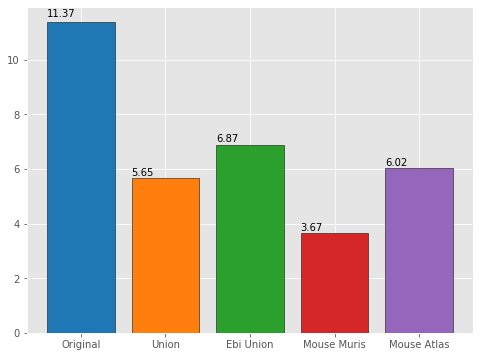

In [13]:

plt.rcParams.update({'font.size': 12})
fig = plt.figure(1,figsize=(8, 6))
plt.style.use("ggplot")
cmap= plt.get_cmap("tab20", 10)
barlist = plt.bar(x=["Original", "Union", "Ebi Union", "Mouse Muris", "Mouse Atlas"], 
                  height=[11.37, 5.65, 6.87, 3.67, 6.02],
                  edgecolor="black",
                 color=cmap.colors[:5])
for rect in barlist:
    print(rect)
    plt.text(x=rect.xy[0], y=rect.get_height()*1.02, s=f"{rect.get_height()}")

plt.savefig("./plots/test2.pdf", image_datatype="pdf", bbox_inches="tight")
plt.show()

In [14]:
likelihood = {tissue: {"orig": log_lhood[tissue], 
                       "data_full": lks[0], 
                       "ebi_data": lks[1], 
                       "atlas": lks[2], 
                       "muris_senis": lks[3]} 
              for tissue, lks in log_likelihood.items()}
l = pd.DataFrame.from_dict(likelihood, orient="index")
l.to_csv("./data/likelihoods.csv")

AttributeError: module 'scvi.models.log_likelihood' has no attribute 'items'

In [15]:
l = pd.read_csv("./data/likelihoods.csv", index_col=0)
l

,orig,data_full,ebi_data,atlas,muris_senis
aorta,24310.315684,23992.295107,32075.558344,4.587417e+06,5.571919e+06
ascending colon,29460.074128,29853.452477,37575.660183,9.460040e+06,9.566490e+06
back skin,30357.389638,29995.718950,36439.681334,5.446716e+06,5.563453e+06
bone marrow,24258.308894,24701.243558,37663.219285,6.975455e+06,5.212873e+06
cerebellum,24374.276993,24772.462810,42134.700080,5.051623e+06,5.300943e+06
cerebral cortex,24435.349372,24767.023523,42151.180968,5.051730e+06,5.294357e+06
descending colon,30182.121101,29853.437064,37576.192294,9.460034e+06,9.566423e+06
diaphragm,23358.448943,23083.066465,32318.528097,4.835733e+06,5.392476e+06
endocrine pancreas,25343.399893,25431.762947,55239.081687,5.808246e+06,5.918684e+06
exocrine pancreas,25318.502936,25431.856914,55233.785371,5.808420e+06,5.918819e+06


Rectangle(xy=(-0.4, 0), width=0.8, height=25680, angle=0)
Rectangle(xy=(0.6, 0), width=0.8, height=25292, angle=0)
Rectangle(xy=(1.6, 0), width=0.8, height=38884, angle=0)
Rectangle(xy=(2.6, 0), width=0.8, height=5.59587e+06, angle=0)
Rectangle(xy=(3.6, 0), width=0.8, height=5.74114e+06, angle=0)


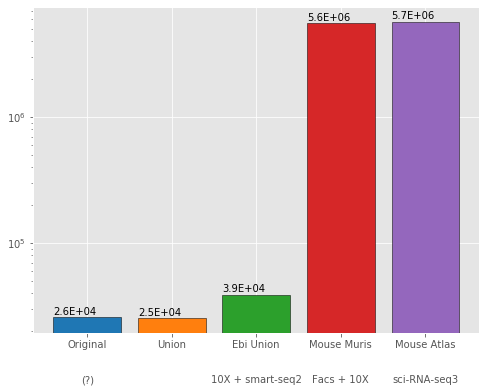

In [16]:
plt.rcParams.update({'font.size': 12})
fig = plt.figure(1,figsize=(8, 6))
plt.style.use("ggplot")
cmap= plt.get_cmap("tab20", 10)
barlist = plt.bar(x=["Original\n\n\n(?)", "Union", "Ebi Union\n\n\n10X + smart-seq2", "Mouse Muris\n\n\nFacs + 10X", "Mouse Atlas\n\n\nsci-RNA-seq3"], 
                  height=l.mean(axis=0).round(0),
                  edgecolor="black",
                 color=cmap.colors[:5])
for rect in barlist:
    print(rect)
    plt.text(x=rect.xy[0], y=rect.get_height()*1.05, s=f"{rect.get_height():.1E}")
ticks = l.mean(axis=0).values.flatten().round(1)
ticks = ticks[np.array([0,2,3])]
plt.yticks(ticks)

plt.yscale("log")
plt.savefig("./plots/test.pdf", image_datatype="pdf", bbox_inches="tight")
plt.show()

In [6]:
l.mean(axis=0)

orig           2.568004e+04
data_full      2.529187e+04
ebi_data       3.888369e+04
atlas          5.595871e+06
muris_senis    5.741138e+06
dtype: float64

'ddfg'